In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

import sklearn
from sklearn.ensemble import RandomForestClassifier
import scikitplot

import matplotlib.pyplot as plt
%matplotlib inline

import mlutil

/opt/anaconda3/envs/nnets/lib/python3.7/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
!wget -nc https://query.data.world/s/plpwlqfrn2xqis5wvpnd6uucus76dq -O ../data/steam_reviews.csv

File ‘../data/steam_reviews.csv’ already there; not retrieving.


### Metacritic game reviews

Data from [kaggle dataset](https://www.kaggle.com/dahlia25/metacritic-video-game-comments)

In [3]:
DATA_PATH = os.path.abspath('../data')
metacritic_game_info_path = os.path.join(DATA_PATH, 'metacritic_game_info.csv')
metacritic_game_comments_path = os.path.join(DATA_PATH, 'metacritic_game_user_comments.csv')
steam_review_path = os.path.join(DATA_PATH, 'steam_reviews.csv')

In [4]:
if not os.path.exists(os.path.abspath(metacritic_game_info_path)):
    !unzip ../data/metacritic-video-game-comments.zip -d ../data
    !chmod +rwx ../data/*csv 

In [5]:
def clean_game_dfs(game_info_df, game_comments_df):
    game_info_df = game_info_df[game_info_df['Metascore'] != 'not specified']
    game_info_df = game_info_df[game_info_df['Avg_Userscore'] != 'not specified']
    game_info_df = game_info_df[game_info_df['Avg_Userscore'] != 'tbd']
    
    for col in ['Metascore', 'Avg_Userscore', 'Year']:
        game_info_df[col] = game_info_df[col].astype('float')
    pc_game_info_df = game_info_df[game_info_df['Platform'] == 'PC']
    pc_game_comments_df = game_comments_df[game_comments_df['Title'].isin(pc_game_info_df['Title'])]
    return pc_game_info_df, pc_game_comments_df

In [6]:
game_info_df = pd.read_csv(metacritic_game_info_path, index_col='Unnamed: 0')
game_comments_df = pd.read_csv(metacritic_game_comments_path, index_col='Unnamed: 0')

pc_game_info_df, pc_game_comments_df = clean_game_dfs(game_info_df, game_comments_df)

In [7]:
pc_game_info_df.head()

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
20,Half-Life 2,2004.0,ValveSoftware,Action;Shooter;Shooter;First-Person;Sci-Fi;Sci...,PC,96.0,9.1,No Online Multiplayer
21,Grand Theft Auto V,2015.0,RockstarNorth,Modern;Action Adventure;Open-World,PC,96.0,7.7,Up to 32
28,The Orange Box,2007.0,ValveSoftware,Action;Miscellaneous;Shooter;Compilation;First...,PC,96.0,9.2,16 Online
34,Half-Life,1998.0,ValveSoftware,Action;Shooter;Shooter;First-Person;Sci-Fi;Sci...,PC,96.0,9.1,1-32
38,BioShock,2007.0,"IrrationalGames,2KMarin",Action;Shooter;Shooter;First-Person;Sci-Fi;Sci...,PC,96.0,8.5,No Online Multiplayer


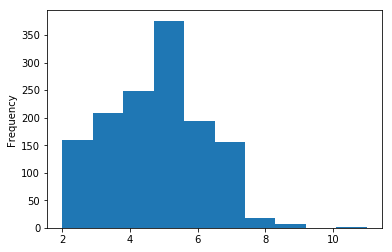

In [8]:
pc_game_info_df['Genre'].str.split(";").apply(len).plot.hist()

In [9]:
pc_game_info_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368 entries, 20 to 4995
Data columns (total 8 columns):
Title            1368 non-null object
Year             1368 non-null float64
Publisher        1368 non-null object
Genre            1368 non-null object
Platform         1368 non-null object
Metascore        1368 non-null float64
Avg_Userscore    1368 non-null float64
No_Players       1367 non-null object
dtypes: float64(3), object(5)
memory usage: 96.2+ KB


In [10]:
pc_game_comments_df.shape

(187517, 5)

## Correlation between user and metascore

In [11]:
np.corrcoef(pc_game_info_df['Avg_Userscore'], pc_game_info_df['Metascore'])[0,1]

0.21381816860581535

### Spearman rank correlation coefficient

In [12]:
scipy.stats.spearmanr(pc_game_info_df['Avg_Userscore'], pc_game_info_df['Metascore'])

SpearmanrResult(correlation=0.2678004214955681, pvalue=6.729732567969086e-24)

### Average user vs metascore

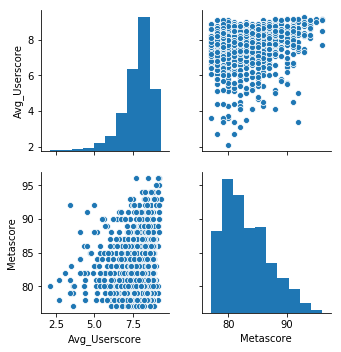

In [13]:
sns.pairplot(pc_game_info_df[['Avg_Userscore', 'Metascore']]);

# Steam reviews

In [14]:
steam_reviews_df = pd.read_csv(steam_review_path)
genre_columns = [col for col in steam_reviews_df if 'Genre' in col]

In [15]:
steam_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13357 entries, 0 to 13356
Data columns (total 78 columns):
QueryID                        13357 non-null int64
ResponseID                     13357 non-null int64
QueryName                      13356 non-null object
ResponseName                   13357 non-null object
ReleaseDate                    13357 non-null object
RequiredAge                    13357 non-null int64
DemoCount                      13357 non-null int64
DeveloperCount                 13357 non-null int64
DLCCount                       13357 non-null int64
Metacritic                     13357 non-null int64
MovieCount                     13357 non-null int64
PackageCount                   13357 non-null int64
RecommendationCount            13357 non-null int64
PublisherCount                 13357 non-null int64
ScreenshotCount                13357 non-null int64
SteamSpyOwners                 13357 non-null int64
SteamSpyOwnersVariance         13357 non-null int64
Stea

In [16]:
steam_reviews_df.describe()

,QueryID,ResponseID,RequiredAge,DemoCount,DeveloperCount,DLCCount,Metacritic,MovieCount,PackageCount,RecommendationCount,PublisherCount,ScreenshotCount,SteamSpyOwners,SteamSpyOwnersVariance,SteamSpyPlayersEstimate,SteamSpyPlayersVariance,AchievementCount,AchievementHighlightedCount,PriceInitial,PriceFinal
count,13357.000000,13357.000000,13357.000000,13357.000000,13357.000000,13357.000000,13357.000000,13357.000000,13357.000000,1.335700e+04,13357.000000,13357.000000,1.335700e+04,13357.000000,1.335700e+04,13357.000000,13357.000000,13357.000000,13357.000000,13357.000000
mean,353637.916149,353471.814030,0.837688,0.089541,1.032492,0.805944,12.285319,1.321255,1.088418,1.180463e+03,0.989668,9.561204,1.668493e+05,5486.408550,1.081638e+05,4082.329490,14.434678,4.170098,9.155717,8.798596
std,146988.380337,147085.351999,3.625701,0.286058,0.437113,10.034901,27.510876,1.178400,0.855219,1.517606e+04,0.336972,6.442893,1.127122e+06,9044.093874,1.006635e+06,7454.869744,41.467021,4.831106,14.345029,13.606061
min,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,282860.000000,282640.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,6.000000,8.970000e+02,906.000000,5.370000e+02,745.000000,0.000000,0.000000,1.990000,1.990000
50%,374040.000000,373870.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,1.000000,8.000000,9.506000e+03,2551.000000,4.125000e+03,1717.000000,0.000000,0.000000,5.990000,5.990000
75%,465920.000000,465860.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,1.000000,2.430000e+02,1.000000,12.000000,6.044100e+04,6434.000000,2.815800e+04,4392.000000,20.000000,10.000000,9.990000,9.990000
max,568150.000000,568150.000000,18.000000,2.000000,12.000000,630.000000,96.000000,20.000000,18.000000,1.427633e+06,4.000000,114.000000,9.068758e+07,215972.000000,9.068758e+07,215972.000000,1629.000000,10.000000,449.990000,449.990000


In [17]:
steam_reviews_df['AboutText'][4]

'Return to the Black Mesa Research Facility as one of the military specialists assigned to eliminate Gordon Freeman. Experience an entirely new episode of single player action. Meet fierce alien opponents and experiment with new weaponry. Named Game of the Year by the Academy of Interactive Arts and Sciences.'

In [18]:
sum(steam_reviews_df['DetailedDescrip'] != steam_reviews_df['AboutText'])

1226

In [19]:
steam_reviews_df[genre_columns].describe()

,GenreIsNonGame,GenreIsIndie,GenreIsAction,GenreIsAdventure,GenreIsCasual,GenreIsStrategy,GenreIsRPG,GenreIsSimulation,GenreIsEarlyAccess,GenreIsFreeToPlay,GenreIsSports,GenreIsRacing,GenreIsMassivelyMultiplayer
count,13357,13357,13357,13357,13357,13357,13357,13357,13357,13357,13357,13357,13357
unique,2,2,2,2,2,2,2,2,2,2,2,2,2
top,False,True,False,False,False,False,False,False,False,False,False,False,False
freq,13038,7780,7724,9038,9793,10734,11270,11255,11887,12692,12816,12881,12968


In [20]:
%%time
word_embedding_vectorizer = mlutil.embeddings.WordEmbeddingsVectorizer.from_gensim_embedding_model('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


CPU times: user 46.7 s, sys: 4.22 s, total: 50.9 s
Wall time: 1min 31s


In [21]:
%%time
steam_description_vectors = word_embedding_vectorizer.transform(steam_reviews_df['DetailedDescrip'])

CPU times: user 5.6 s, sys: 0 ns, total: 5.6 s
Wall time: 5.6 s


In [22]:
steam_description_vectors.shape

(13357, 100)

## Genre classification using description

Note this is multilabel classification, as games on steam can have several genres

We'll use Random Forest algorithm as it supports mutlilabel classification out of the box

In [23]:
X = steam_description_vectors
Y = steam_reviews_df[genre_columns]

X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.2)

In [24]:
rf_clf = RandomForestClassifier(n_estimators=50, n_jobs=-1)
rf_clf.fit(X_train, Y_train)

Y_test_pred = rf_clf.predict(X_test)

In [25]:
Y_test.shape

(2672, 13)

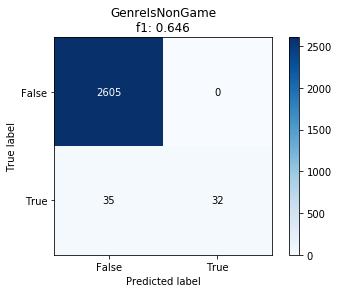

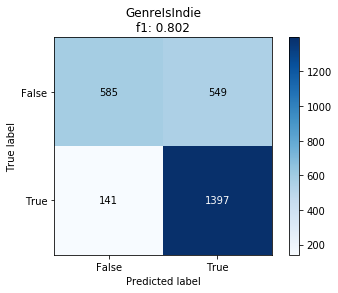

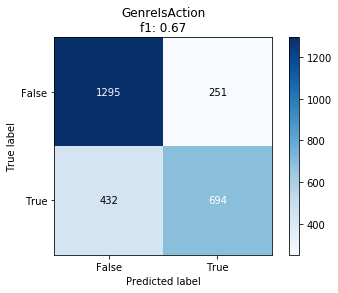

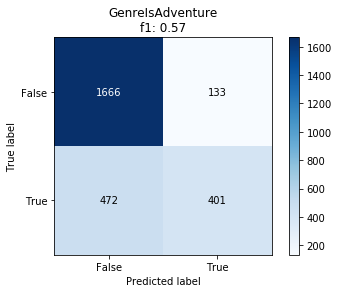

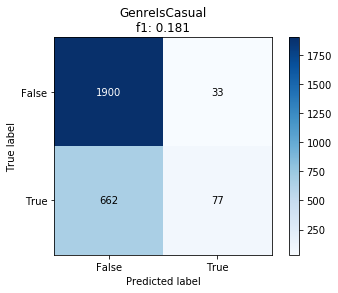

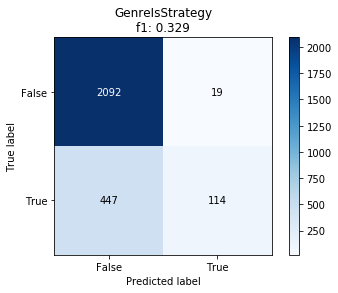

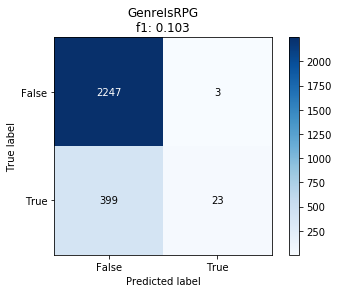

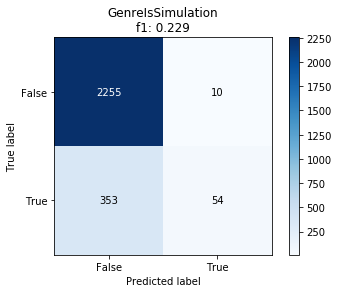

/opt/anaconda3/envs/nnets/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


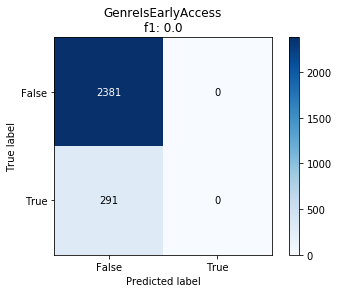

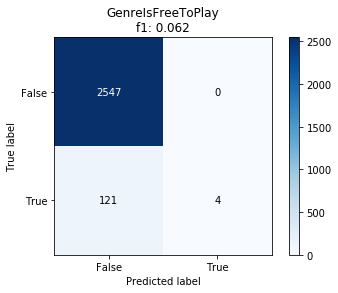

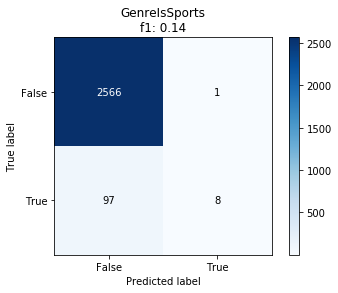

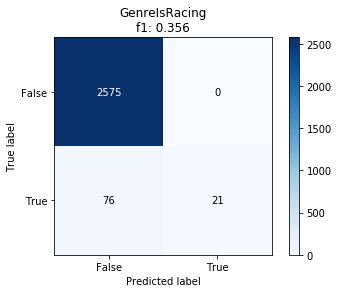

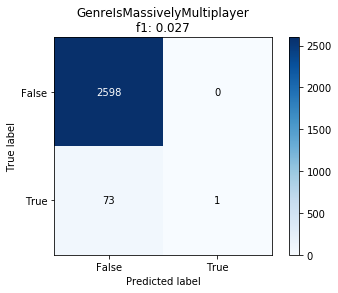

In [26]:
for i, col in enumerate(genre_columns):
    pred = Y_test_pred[:, i]
    y = Y_test.iloc[:, i]
    f1_score = round(sklearn.metrics.f1_score(pred, y), 3)
    scikitplot.metrics.plot_confusion_matrix(y, pred)
    plt.title(col + '\nf1: ' + str(f1_score))
    plt.show()